# 1. Use SAM for Image Segmentation
# 2. Use Pose Detection to find the pose of the person
# 3. Segment Diffrent parts of the body

# Directory class

In [3]:
import cv2
import matplotlib.pyplot as plt
import os

class DirectoryBuddy:
    
    def __init__(self, parent_directory_path):
        
        if not os.path.isdir(parent_directory_path):
            raise ValueError("Invalid directory path.")
        
        self.parent_directory_path = parent_directory_path
        self.parent_directory = os.listdir(parent_directory_path)
    
    def rename_image_paths(self, show_path=False):
        
        for folder_name in self.parent_directory:
            folder_path = os.path.join(self.parent_directory_path, folder_name)
            
            for i, filename in enumerate(os.listdir(folder_path)):
                image_path = os.path.join(folder_path, filename)
                
                if not os.path.isfile(image_path):
                    continue
                
                new_image_name = os.path.join(folder_path, f"{i}.jpg")
                
                if show_path:
                    print(image_path+ " -> " + new_image_name)
                
                try:
                    os.rename(image_path, new_image_name)
                except OSError as e:
                    print(f"Error renaming file: {e}")
    
    def show_image(self, image_path):
        
        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except:
            pass
        
       
        
    def show_image(self, image):
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        except:
            pass              
            
            
    def create_image_array(self,show=False):
        
        folder_dictionary={}
        for folder_name in self.parent_directory:
            folder_path = os.path.join(self.parent_directory_path, folder_name)
            
            image_array=[]
            
            
            for i, filename in enumerate(os.listdir(folder_path)):
                image_path = os.path.join(folder_path, filename)
                
                image=cv2.imread(image_path)
                image_array.append(image)  
                if show:
                    self.show_image(image)
                    
            folder_dictionary[folder_name]=[image_array,image_path]
            
        return folder_dictionary
    
    def export_to_directory(self, export_directory,callback_function):
    
        if not os.path.isdir(export_directory):
            os.mkdir(export_directory)
            
        for folder_name in self.parent_directory:
            folder_path=os.path.join(self.parent_directory_path,folder_name)#../raw/good
            folder=os.listdir(folder_path)
            folder.sort()
            
            export_path=os.path.join(export_directory,folder_name)
            print(export_path)
            
            try :
                os.mkdir(export_path)
            except:
                pass    
                    
            for i in range(0,len(folder)):
            
                image_path=os.path.join(folder_path,folder[i])
                export_image_path=os.path.join(export_path,folder[i])
                
                box=callback_function(image_path)
                flag=cv2.imwrite(export_image_path,box)
                
                print(export_image_path + ' : ' + str(flag))    
                
director=DirectoryBuddy('../raw')

# Detector class

In [4]:
from super_gradients.training import models
import matplotlib.pyplot as plt
import cv2

class DetectBuddy():
    
    def __init__(self,model_name='yolo_nas_l',weights='coco',conf_threshold=0.8):
        self.model = models.get(model_name, pretrained_weights=weights)
        self.conf_threshold=conf_threshold
        self.detection_list=[]
        
    def predict_human(self,image_path,show=False):
        
        prediction = self.model.predict(image_path, conf=self.conf_threshold)
        if show:
            prediction.show()
        
        detection_pred = prediction._images_prediction_lst
        self.detection_list = list(detection_pred)
        
    
    
    def predict_human(self,image,show=False):
        prediction = self.model.predict(image, conf=self.conf_threshold)
        if show:
            prediction.show()
        
        detection_pred = prediction._images_prediction_lst
        self.detection_list = list(detection_pred)
 
        
detect=DetectBuddy()


/home/sampurn/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2023-07-16 20:51:45] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/sampurn/sg_logs/console.log


[2023-07-16 20:51:47] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-07-16 20:51:47] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-07-16 20:51:47] WARNING - export.py - Failed to import pytorch_quantization
[2023-07-16 20:51:47] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-07-16 20:51:47] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


# Segmentor class

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

import sys
sys.path.append("..")
from super_gradients.training import models
from segment_anything import  SamPredictor
import numpy as np
import cv2



class SegmentBuddy():
    
    ##### CODE FROM DOCUMENTATION #####
    def show_mask(mask, ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    def show_points(coords, labels, ax, marker_size=375):
        pos_points = coords[labels==1]
        neg_points = coords[labels==0]
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

    def show_box(box, ax):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

    def show_anns(anns):
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        for ann in sorted_anns:
            m = ann['segmentation']
            img = np.ones((m.shape[0], m.shape[1], 3))
            color_mask = np.random.random((1, 3)).tolist()[0]
            for i in range(3):
                img[:, :, i] = color_mask[i]
            ax.imshow(np.dstack((img, m * 0.35)))
            
    ##### CODE FROM DOCUMENTATION #####
    
    
    
    def __init__(self,path_to_checkpoints, model_type="vit_h",device="cuda" if torch.cuda.is_available() else "cpu"):
        
        self.sam = sam_model_registry[model_type] (checkpoint=path_to_checkpoints)
        self.sam.to (device=device)
        
        self.mask_generator = SamAutomaticMaskGenerator (self.sam)
        
        self.predictor = SamPredictor(self.sam)
            
            
    def segment_person(self,image_path,show_mask=False):
        
        
        detect.predict_human(image_path)

        
        detection_list = detect.detection_list

        
        bboxes_xyxy = detection_list[0].prediction.bboxes_xyxy.tolist()
        labels = detection_list[0].prediction.labels.tolist()
        
        image = cv2.imread(image_path)
        
        masks = self.mask_generator.generate(image)

        self.predictor.set_image(image)

        image = image.transpose((2, 0, 1))  # Transpose to match SAM input format
        image = image / 255.0  # Normalize image values to [0, 1]
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        input_box = np.array(bboxes_xyxy[0])
        
        if labels[0] == 0:
           
            masks, _, _ = self.predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )
    
        masked_image = cv2.bitwise_and(image[0].transpose((1, 2, 0)), image[0].transpose((1, 2, 0)), mask=masks[0].astype(np.uint8))
        
        
        if show_mask:
            plt.imshow(image[0].transpose((1, 2, 0)))
            if labels[0] == 0:
                plt.imshow(masks[0], alpha=0.5)
                
       
        return masked_image

        
segmentor=SegmentBuddy("../resources/sam_vit_h_4b8939.pth")       

In [6]:
masked_image=segmentor.segment_person("../preprocessed-data/good_ankle/9.jpg")

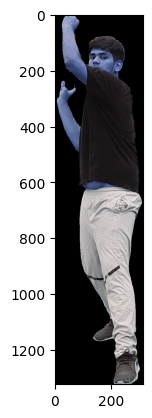

In [7]:
plt.imshow(masked_image)

In [8]:
masked_image= cv2.convertScaleAbs(masked_image, alpha=(255.0))
cv2.imwrite("../segmented-data/test.jpg",masked_image)

True

In [6]:
director.export_to_directory('../segmented-data',segmentor.segment_person)

../segmented-data/bad_ankle_right
